Nota sobre ingresos: unsupported format character 'I' (0x49) at index 261. Generando datos simulados para ingresos.
Nota sobre gastos generales: must be real number, not dict. Generando datos simulados para gastos generales problemáticos.
Forzando simulación de datos de nómina problemáticos.
Nota sobre gastos de nómina: Simulating problematic payroll data. Generando datos simulados para nómina problemáticos.
Usando ingresos (reales o simulados) de 2021 (1,010,170,506.56) como base para el presupuesto.

--- Ingresos y Gastos Totales Mensuales (con simulación si fue necesario) ---
          mes        ingresos gastos_generales  gastos_nomina  gastos_totales  \
0  2021-01-01   86,528,299.43    30,465,874.32  35,613,626.75   66,079,501.07   
1  2021-02-01   68,652,018.11    24,094,042.72  35,519,686.28   59,613,728.99   
2  2021-03-01   69,564,910.19    24,881,794.59  35,372,490.69   60,254,285.28   
3  2021-04-01   79,134,353.04    28,777,922.21  35,403,826.28   64,181,748.49   
4  2021-0

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_28800\3265512469.py:101: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



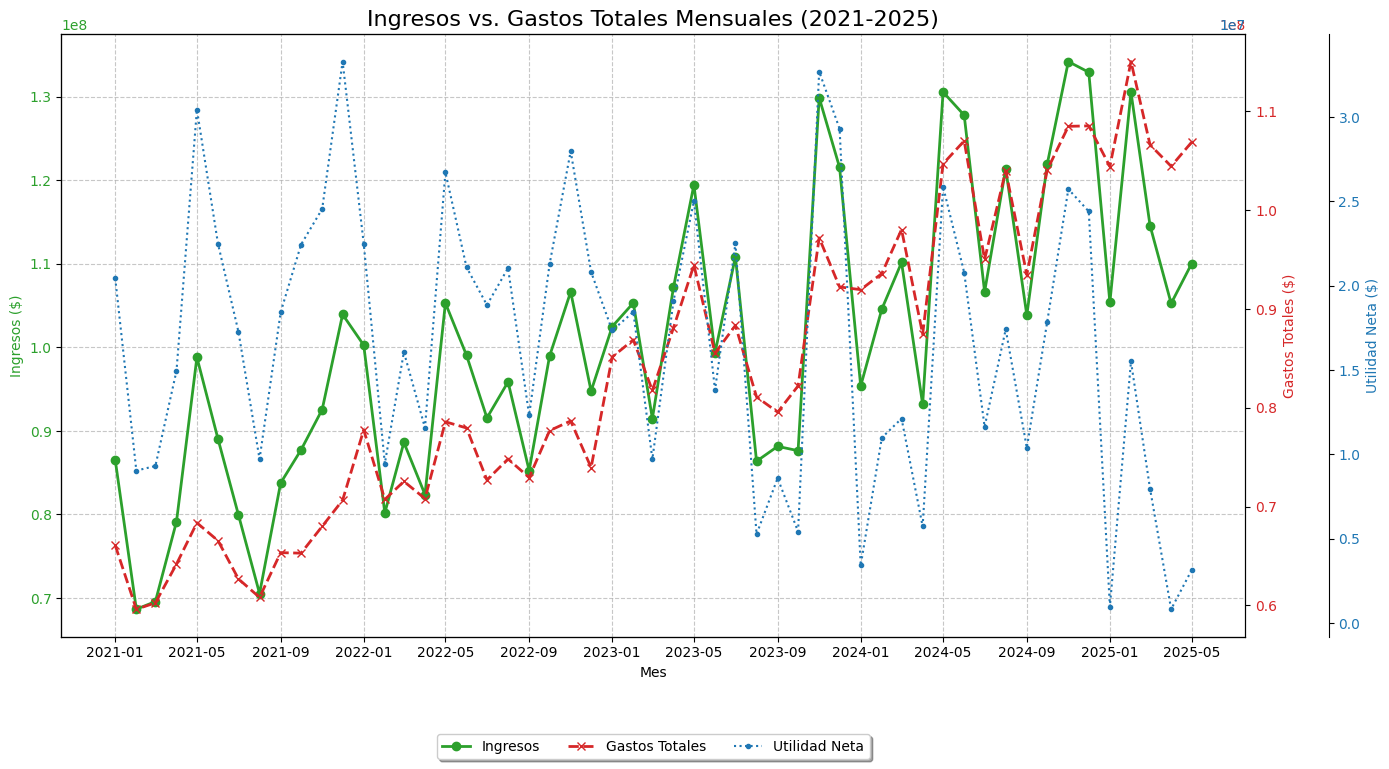


Gráfico generado con éxito.


In [116]:
from sqlalchemy import create_engine
import pandas as pd
from urllib.parse import quote_plus
import numpy as np
import datetime

usuario = "root"
contraseña = "3112708652El"
host = "localhost"
puerto = 3306
basededatos = "demo_wft"

contraseña_escapada = quote_plus(contraseña)
engine = create_engine(f"mysql+pymysql://{usuario}:{contraseña_escapada}@{host}:{puerto}/{basededatos}")

date_column_movements = "date"
account_id_column_movements = "account_id"
debit_column_movements = "debit_movement"
credit_column_movements = "credit_movement"

account_id_column_accounts = "id"
account_name_column = "name"
account_code_column = "code"

payroll_table_name = "payrolls"
date_column_payroll = "end_date"
amount_column_payroll = "total_payment"

start_year = 2021
end_year = 2025

all_months_list = []
current_year_val = datetime.datetime.now().year
current_month_val = datetime.datetime.now().month

for year_loop in range(start_year, end_year + 1):
    limit_month = 12
    if year_loop == current_year_val and year_loop == end_year:
        limit_month = current_month_val
    for month_loop in range(1, limit_month + 1):
        if year_loop == current_year_val and month_loop > current_month_val and year_loop == end_year:
            continue
        all_months_list.append(pd.Timestamp(f'{year_loop}-{month_loop:02d}-01'))

df_meses_base = pd.DataFrame({'mes': all_months_list})
df_meses_base['mes'] = pd.to_datetime(df_meses_base['mes'])

query_ingresos = f"""
SELECT
    DATE_FORMAT(am.{date_column_movements}, '%%Y-%%m-01') AS mes,
    SUM(am.{credit_column_movements} - am.{debit_column_movements}) AS ingresos
FROM accounting_movements am
JOIN accounting_accounts aa ON am.{account_id_column_movements} = aa.{account_id_column_accounts}
WHERE YEAR(am.{date_column_movements}) BETWEEN {start_year} AND {end_year}
  AND (aa.{account_name_column} LIKE '%Ingreso%' OR aa.{account_name_column} LIKE '%Venta%' OR aa.{account_code_column} LIKE '4%')
GROUP BY mes
ORDER BY mes;
"""
try:
    df_ingresos_hist = pd.read_sql(query_ingresos, engine)
    df_ingresos_hist['mes'] = pd.to_datetime(df_ingresos_hist['mes'])
    if df_ingresos_hist.empty or df_ingresos_hist['ingresos'].sum() == 0:
        print("Ingresos no encontrados o son cero. Se generarán datos simulados para ingresos.")
        raise ValueError("Simulating income data")
except Exception as e:
    print(f"Nota sobre ingresos: {e}. Generando datos simulados para ingresos.")
    ingresos_simulados = []
    base_ingreso_mensual = 80_000_000
    crecimiento_anual_ingresos = 1.10
    for fecha_mes in df_meses_base['mes']:
        año_actual = fecha_mes.year
        mes_actual = fecha_mes.month
        ingreso_actual = base_ingreso_mensual * (crecimiento_anual_ingresos ** (año_actual - start_year))
        ingreso_actual *= np.random.uniform(0.85, 1.15)
        if mes_actual == 5 or mes_actual == 6: ingreso_actual *= 1.10
        if mes_actual == 11 or mes_actual == 12: ingreso_actual *= 1.20
        ingresos_simulados.append(ingreso_actual)
    df_ingresos_hist = pd.DataFrame({'mes': df_meses_base['mes'], 'ingresos': ingresos_simulados})


query_gastos_generales = f"""
SELECT
    DATE_FORMAT(am.{date_column_movements}, '%%Y-%%m-01') AS mes,
    SUM(am.{debit_column_movements} - am.{credit_column_movements}) AS gastos_generales
FROM accounting_movements am
JOIN accounting_accounts aa ON am.{account_id_column_movements} = aa.{account_id_column_accounts}
WHERE YEAR(am.{date_column_movements}) BETWEEN {start_year} AND {end_year}
  AND (aa.{account_name_column} LIKE '%Gasto%' OR aa.{account_name_column} LIKE '%Costo%' OR aa.{account_code_column} LIKE '5%' OR aa.{account_code_column} LIKE '6%')
  AND NOT (aa.{account_name_column} LIKE '%Nomina%' OR aa.{account_name_column} LIKE '%Sueldo%')
GROUP BY mes
ORDER BY mes;
"""
try:
    df_gastos_gen_hist = pd.read_sql(query_gastos_generales, engine)
    df_gastos_gen_hist['mes'] = pd.to_datetime(df_gastos_gen_hist['mes'])
    if df_gastos_gen_hist.empty or df_gastos_gen_hist['gastos_generales'].sum() == 0:
        print("Gastos generales no encontrados o son cero. Se generarán datos simulados para gastos generales problemáticos.")
        raise ValueError("Simulating problematic general expenses data")
except Exception as e:
    print(f"Nota sobre gastos generales: {e}. Generando datos simulados para gastos generales problemáticos.")
    df_temp_gastos = pd.merge(df_meses_base, df_ingresos_hist, on='mes', how='left').fillna(method='ffill').fillna(method='bfill')
    gastos_gen_simulados = []
    porcentaje_gasto_inicial = 0.35
    crecimiento_porcentaje_gasto_anual = 0.03

    for index, row in df_temp_gastos.iterrows():
        año_actual = row['mes'].year
        porcentaje_gasto_actual = porcentaje_gasto_inicial + (crecimiento_porcentaje_gasto_anual * (año_actual - start_year))
        porcentaje_gasto_actual = min(porcentaje_gasto_actual, 0.60)
        gasto_actual = row['ingresos'] * porcentaje_gasto_actual
        gasto_actual *= np.random.uniform(0.95, 1.05)
        gastos_gen_simulados.append(gasto_actual)
    df_gastos_gen_hist = pd.DataFrame({'mes': df_meses_base['mes'], 'gastos_generales': gastos_gen_simulados})

query_nomina_hist = f"""
SELECT
    DATE_FORMAT({date_column_payroll}, '%%Y-%%m-01') AS mes,
    SUM({amount_column_payroll}) AS gastos_nomina
FROM {payroll_table_name}
WHERE {date_column_payroll} BETWEEN '{start_year}-01-01' AND '{end_year}-12-31'
GROUP BY mes
ORDER BY mes;
"""
try:
    df_nomina_hist = pd.read_sql(query_nomina_hist, engine)
    df_nomina_hist['mes'] = pd.to_datetime(df_nomina_hist['mes'])
    
    FORCE_SIMULATE_PAYROLL = True

    if FORCE_SIMULATE_PAYROLL or df_nomina_hist.empty or df_nomina_hist['gastos_nomina'].sum() == 0:
        if not FORCE_SIMULATE_PAYROLL:
            print("Gastos de nómina no encontrados o son cero en la BD. Se generarán datos simulados para nómina problemáticos.")
        else:
            print("Forzando simulación de datos de nómina problemáticos.")
        raise ValueError("Simulating problematic payroll data")
except Exception as e:
    print(f"Nota sobre gastos de nómina: {e}. Generando datos simulados para nómina problemáticos.")
    nomina_simulada = []
    base_nomina_mensual = 35_000_000
    crecimiento_anual_nomina = 1.12
    

    for fecha_mes in df_meses_base['mes']:
        año_actual = fecha_mes.year
        nomina_actual = base_nomina_mensual * (crecimiento_anual_nomina ** (año_actual - start_year))
        

        nomina_actual *= np.random.uniform(0.98, 1.02)
        nomina_simulada.append(nomina_actual)
    df_nomina_hist = pd.DataFrame({'mes': df_meses_base['mes'], 'gastos_nomina': nomina_simulada})


df_totales = pd.merge(df_meses_base, df_ingresos_hist, on='mes', how='left')
df_totales = pd.merge(df_totales, df_gastos_gen_hist, on='mes', how='left')
df_totales = pd.merge(df_totales, df_nomina_hist, on='mes', how='left')

df_totales['ingresos'] = df_totales['ingresos'].fillna(0)
df_totales['gastos_generales'] = df_totales['gastos_generales'].fillna(0)
df_totales['gastos_nomina'] = df_totales['gastos_nomina'].fillna(0)

df_totales['gastos_totales'] = df_totales['gastos_generales'] + df_totales['gastos_nomina']
df_totales['utilidad_neta'] = df_totales['ingresos'] - df_totales['gastos_totales']

presupuestos_anuales = []
primer_año_base_presupuesto = start_year
ingresos_primer_año = df_totales[df_totales['mes'].dt.year == primer_año_base_presupuesto]['ingresos'].sum()

if ingresos_primer_año > 0:
    base_ingresos_anual = ingresos_primer_año
    print(f"Usando ingresos (reales o simulados) de {primer_año_base_presupuesto} ({base_ingresos_anual:,.2f}) como base para el presupuesto.")
else:
    base_ingresos_anual = 80_000_000 * 12
    print(f"No se encontraron ingresos significativos en {primer_año_base_presupuesto} para el presupuesto. Usando base arbitraria: {base_ingresos_anual:,.2f}")

crecimiento_anual_presupuesto = 1.10

for year_iter in range(start_year, end_year + 1):
    if year_iter == primer_año_base_presupuesto:
        presupuesto_año = base_ingresos_anual
    elif year_iter < primer_año_base_presupuesto:
        presupuesto_año = base_ingresos_anual / (crecimiento_anual_presupuesto ** (primer_año_base_presupuesto - year_iter))
    else:
        presupuesto_año = base_ingresos_anual * (crecimiento_anual_presupuesto ** (year_iter - primer_año_base_presupuesto))
    presupuestos_anuales.append({'año': year_iter, 'presupuesto_ingresos_esperado': presupuesto_año})

df_presupuesto_anual = pd.DataFrame(presupuestos_anuales)

print("\n--- Ingresos y Gastos Totales Mensuales (con simulación si fue necesario) ---")
df_totales_print = df_totales.copy()
for col in ['ingresos', 'gastos_generales', 'gastos_nomina', 'gastos_totales', 'utilidad_neta']:
    df_totales_print[col] = df_totales_print[col].map('{:,.2f}'.format)
print(df_totales_print[['mes', 'ingresos', 'gastos_generales', 'gastos_nomina', 'gastos_totales', 'utilidad_neta']].sort_values(by='mes').reset_index(drop=True))

print("\n--- Presupuesto Anual de Ingresos Esperado vs. Real ---")
df_ingresos_reales_anuales = df_totales.groupby(df_totales['mes'].dt.year)['ingresos'].sum().reset_index()
df_ingresos_reales_anuales.rename(columns={'mes': 'año', 'ingresos': 'ingresos_reales'}, inplace=True)

df_comparativa_presupuesto = pd.merge(df_presupuesto_anual, df_ingresos_reales_anuales, on='año', how='left')
df_comparativa_presupuesto['ingresos_reales'] = df_comparativa_presupuesto['ingresos_reales'].fillna(0)
df_comparativa_presupuesto['diferencia'] = df_comparativa_presupuesto['ingresos_reales'] - df_comparativa_presupuesto['presupuesto_ingresos_esperado']

for col in ['ingresos_reales', 'presupuesto_ingresos_esperado', 'diferencia']:
    df_comparativa_presupuesto[col] = df_comparativa_presupuesto[col].map('{:,.2f}'.format)

print(df_comparativa_presupuesto.set_index('año'))

try:
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    fig, ax1 = plt.subplots(figsize=(14, 7))

    color_ingresos = 'tab:green'
    ax1.set_xlabel('Mes')
    ax1.set_ylabel('Ingresos ($)', color=color_ingresos)
    ax1.plot(df_totales['mes'], df_totales['ingresos'], color=color_ingresos, label='Ingresos', marker='o', linestyle='-', linewidth=2)
    ax1.tick_params(axis='y', labelcolor=color_ingresos)
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax2 = ax1.twinx()
    color_gastos = 'tab:red'
    ax2.set_ylabel('Gastos Totales ($)', color=color_gastos)
    ax2.plot(df_totales['mes'], df_totales['gastos_totales'], color=color_gastos, label='Gastos Totales', marker='x', linestyle='--', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color_gastos)
    
    color_utilidad = 'tab:blue'
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    ax3.plot(df_totales['mes'], df_totales['utilidad_neta'], color=color_utilidad, label='Utilidad Neta', marker='.', linestyle=':', linewidth=1.5)
    ax3.set_ylabel('Utilidad Neta ($)', color=color_utilidad)
    ax3.tick_params(axis='y', labelcolor=color_utilidad)


    plt.title(f'Ingresos vs. Gastos Totales Mensuales ({start_year}-{end_year})', fontsize=16)
    fig.tight_layout()

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    num_months = len(df_totales['mes'].unique())
    interval = max(1, num_months // 12)
    if num_months <=12 : interval = 1

    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    plt.xticks(rotation=45, ha="right")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax3.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True, shadow=True)


    plt.show()
    print("\nGráfico generado con éxito.")

except ImportError:
    print("\nMatplotlib no está instalado. No se generó el gráfico. Puedes instalarlo con: pip install matplotlib")
except Exception as e:
    print(f"No se pudo generar el gráfico: {e}")





Mostrando comparación para los años: [2022, 2023, 2024, 2025]


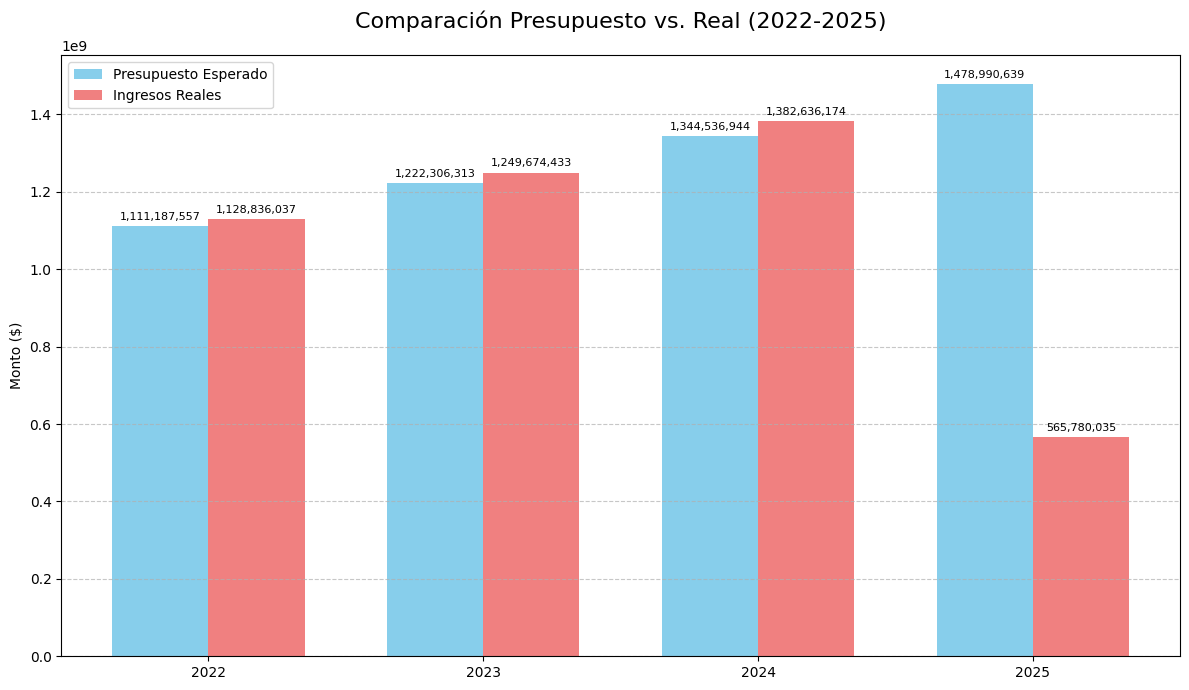

In [117]:

current_display_year = end_year
num_previous_years = 3
years_to_display = list(range(current_display_year - num_previous_years, current_display_year + 1))
print(f"Mostrando comparación para los años: {years_to_display}")

try:
    if 'df_presupuesto_anual' not in locals() or 'df_ingresos_reales_anuales' not in locals():
        print("Asegúrate de que las DataFrames 'df_presupuesto_anual' y 'df_ingresos_reales_anuales'")
        print("hayan sido creadas en la celda anterior con datos numéricos.")
        
        if 'df_totales' in locals() and not df_totales.empty and 'start_year' in locals() and 'end_year' in locals():
            print("Intentando recrear DataFrames necesarias desde 'df_totales'...")
            df_ingresos_reales_anuales = df_totales.groupby(df_totales['mes'].dt.year)['ingresos'].sum().reset_index()
            df_ingresos_reales_anuales.rename(columns={'mes': 'año', 'ingresos': 'ingresos_reales'}, inplace=True)
            
            presupuestos_anuales_temp = []
            ingresos_primer_año_temp = df_totales[df_totales['mes'].dt.year == start_year]['ingresos'].sum()
            base_ingresos_anual_temp = ingresos_primer_año_temp if ingresos_primer_año_temp > 0 else (80_000_000 * 12)
            crecimiento_anual_presupuesto_temp = 1.10
            for year_iter_temp in range(start_year, end_year + 1):
                if year_iter_temp == start_year: presupuesto_año_temp = base_ingresos_anual_temp
                else: presupuesto_año_temp = base_ingresos_anual_temp * (crecimiento_anual_presupuesto_temp ** (year_iter_temp - start_year))
                presupuestos_anuales_temp.append({'año': year_iter_temp, 'presupuesto_ingresos_esperado': presupuesto_año_temp})
            df_presupuesto_anual = pd.DataFrame(presupuestos_anuales_temp)
            print("DataFrames recreadas. Continúa la ejecución.")
        else:
            raise NameError("DataFrames base no encontradas y no se pudieron recrear.")


    df_comparativa_numerica = pd.merge(df_presupuesto_anual, df_ingresos_reales_anuales, on='año', how='left')
    df_comparativa_numerica['ingresos_reales'] = df_comparativa_numerica['ingresos_reales'].fillna(0)

    df_plot_years = df_comparativa_numerica[df_comparativa_numerica['año'].isin(years_to_display)].copy()

    if df_plot_years.empty:
        print(f"No se encontraron datos para los años seleccionados: {years_to_display}")
    else:
        labels = df_plot_years['año'].astype(str)
        presupuesto_valores = df_plot_years['presupuesto_ingresos_esperado']
        reales_valores = df_plot_years['ingresos_reales']

        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 7))
        rects1 = ax.bar(x - width/2, presupuesto_valores, width, label='Presupuesto Esperado', color='skyblue')
        rects2 = ax.bar(x + width/2, reales_valores, width, label='Ingresos Reales', color='lightcoral')

        ax.set_ylabel('Monto ($)')
        ax.set_title(f'Comparación Presupuesto vs. Real ({min(years_to_display)}-{max(years_to_display)})', fontsize=16, pad=20)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend(loc='upper left')

        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        
        def autolabel(rects):
            """Adjunta una etiqueta de texto encima de cada barra en *rects*, mostrando su altura."""
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{:,.0f}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8, rotation=0)

        autolabel(rects1)
        autolabel(rects2)

        fig.tight_layout()
        plt.show()

except NameError as ne:
     print(f"Error: {ne}")
     print("Asegúrate de haber ejecutado la celda anterior que define 'df_presupuesto_anual' y 'df_ingresos_reales_anuales',")
     print("o que 'df_totales', 'start_year', y 'end_year' estén disponibles para recrearlas.")
except KeyError as ke:
    print(f"Error de columna: {ke}. Verifica que las DataFrames tengan las columnas esperadas ('año', 'presupuesto_ingresos_esperado', 'ingresos_reales').")
except Exception as e:
    print(f"Ocurrió un error inesperado al generar la gráfica de barras: {e}")

--- Conexión a la base de datos establecida para CxC ---

--- Cargando datos iniciales... ---
Documentos cargados: 1476
La carga de 'opening_receivable_payable_balances' se omitirá porque 'value_ob_type_receivable' no ha sido configurado (sigue siendo '???').
Contactos cargados: 260

--- Cargando y procesando pagos... ---
Registros de 'Recibos de Caja' (tabla payments) cargados: 614
Total de CxC real calculado (facturas + saldos iniciales): 73,432,592,930.33

--- Análisis de Antigüedad de Saldos por Cobrar ---


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_28800\1249861860.py:114: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



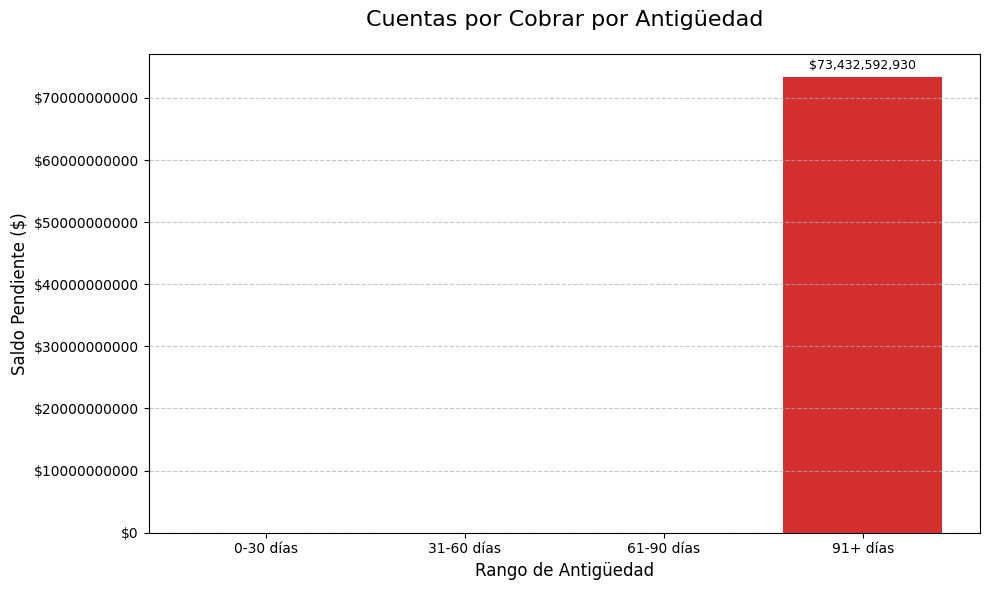


--- Principales Deudores ---
                     Cliente    Saldo Pendiente
                     ase sas $59,610,727,828.24
              Diomar Empresa  $8,035,304,222.01
               Diana Londoño  $1,317,813,342.54
Andres Felipe Londoño Alzate    $874,960,709.11
              MAC ACCESORIOS    $276,937,500.00
             jhonatan arenas    $241,066,520.22
                 Alimentos A    $181,671,022.15
          Computadores la 14    $157,900,000.00
        Alejandro Echavarría    $156,179,442.43
        Acompañamiento S.A.S    $147,366,815.21

--- Fin del Análisis de CxC ---


In [118]:


table_documents = "documents"
col_doc_id = "id"
col_doc_contact_id = "contact_id"
col_doc_date = "document_date" 
col_doc_total_amount = "total"
col_doc_type = None 
value_doc_type_sales_invoice = None 

table_payments = "payments"
col_payment_record_id = "id"
col_payment_details_json = "details" 
key_in_json_invoice_id = "id"    
key_in_json_payment_value = "paymentValue" 

table_opening_balances = "opening_receivable_payable_balances"
col_ob_contact_id = "contact_id"    
col_ob_amount = "value"            
col_ob_type = "operation_type"
value_ob_type_receivable = "???"
col_ob_date_for_aging = "expiration_date" 

table_contacts = "contacts"
col_contact_id = "id"               
col_contact_name = "full_name"      

current_date_for_aging = pd.Timestamp('2025-05-20')

FORCE_SIMULATE_PROBLEMATIC_CXC = False 
MIN_TOTAL_RECEIVABLES_TO_AVOID_SIMULATION = 1000000 

try:
    contraseña_escapada = quote_plus(contraseña)
    engine = create_engine(f"mysql+pymysql://{usuario}:{contraseña_escapada}@{host}:{puerto}/{basededatos}")
    print("--- Conexión a la base de datos establecida para CxC ---")

    print("\n--- Cargando datos iniciales... ---")
    doc_filter_sql = ""
    if col_doc_type and value_doc_type_sales_invoice:
        doc_filter_sql = f"WHERE {col_doc_type} = '{value_doc_type_sales_invoice}'"
    query_docs = f"SELECT {col_doc_id}, {col_doc_contact_id}, {col_doc_date}, {col_doc_total_amount} FROM {table_documents} {doc_filter_sql}"
    df_docs = pd.read_sql(query_docs, engine)
    df_docs[col_doc_date] = pd.to_datetime(df_docs[col_doc_date], errors='coerce')
    if col_doc_total_amount != 'invoice_total':
        df_docs.rename(columns={col_doc_total_amount: 'invoice_total'}, inplace=True)
    else:
        df_docs['invoice_total'] = df_docs[col_doc_total_amount]
    print(f"Documentos cargados: {len(df_docs)}")

    df_ob = pd.DataFrame(columns=[col_ob_contact_id, col_ob_amount, col_ob_date_for_aging])
    if table_opening_balances and col_ob_contact_id and col_ob_amount and col_ob_date_for_aging and col_ob_type and value_ob_type_receivable != "???":
        try:
            ob_filter_sql = f"WHERE {col_ob_type} = '{value_ob_type_receivable}'"
            query_ob = f"SELECT {col_ob_contact_id}, {col_ob_amount}, {col_ob_date_for_aging} FROM {table_opening_balances} {ob_filter_sql}"
            df_ob_loaded = pd.read_sql(query_ob, engine)
            if not df_ob_loaded.empty:
                df_ob = df_ob_loaded
                df_ob[col_ob_date_for_aging] = pd.to_datetime(df_ob[col_ob_date_for_aging], errors='coerce')
                print(f"Saldos iniciales por cobrar cargados: {len(df_ob)}")
            else:
                print(f"La tabla '{table_opening_balances}' está vacía o no contiene saldos del tipo '{value_ob_type_receivable}'.")
        except Exception as e_ob:
            print(f"Advertencia: Error al cargar saldos iniciales de '{table_opening_balances}': {e_ob}.")
    else:
        if value_ob_type_receivable == "???":
            print(f"La carga de '{table_opening_balances}' se omitirá porque 'value_ob_type_receivable' no ha sido configurado (sigue siendo '???').")
        else:
            print(f"La tabla '{table_opening_balances}' se omitirá (configuración esencial faltante o tabla vacía según inspección previa).")
        
    query_contacts = f"SELECT {col_contact_id}, {col_contact_name} FROM {table_contacts}"
    df_contacts = pd.read_sql(query_contacts, engine)
    print(f"Contactos cargados: {len(df_contacts)}")

    print("\n--- Cargando y procesando pagos... ---")
    query_payments = f"SELECT {col_payment_record_id}, {col_payment_details_json} FROM {table_payments}"
    df_payments_raw = pd.read_sql(query_payments, engine)
    print(f"Registros de 'Recibos de Caja' (tabla {table_payments}) cargados: {len(df_payments_raw)}")
    all_payment_applications = []
    for index, row in df_payments_raw.iterrows():
        payment_record_id = row[col_payment_record_id]
        details_json_str = row[col_payment_details_json]
        try:
            details_list = json.loads(details_json_str)
            for payment_detail in details_list:
                original_invoice_id = payment_detail.get(key_in_json_invoice_id)
                payment_value_str = payment_detail.get(key_in_json_payment_value)
                if original_invoice_id is not None and payment_value_str is not None:
                    try:
                        payment_value_num = float(str(payment_value_str).replace(',', ''))
                        all_payment_applications.append({'applied_to_invoice_id': original_invoice_id, 'paid_amount': payment_value_num})
                    except ValueError:
                        if pd.notna(payment_value_str): print(f"Advertencia: No se pudo convertir '{key_in_json_payment_value}' ({payment_value_str}) a número para recibo ID {payment_record_id}, factura aplicada ID {original_invoice_id}.")
        except (TypeError, json.JSONDecodeError) as e:
            if pd.notna(details_json_str): print(f"Advertencia: Error al procesar JSON en '{col_payment_details_json}' para recibo ID {payment_record_id}: {e}.")
    df_payment_applications = pd.DataFrame(all_payment_applications)
    if not df_payment_applications.empty:
        df_payments_agg = df_payment_applications.groupby('applied_to_invoice_id')['paid_amount'].sum().reset_index()
        df_payments_agg.rename(columns={'paid_amount': 'total_paid', 'applied_to_invoice_id': col_doc_id}, inplace=True)
    else:
        df_payments_agg = pd.DataFrame(columns=[col_doc_id, 'total_paid'])

    df_docs_merged = pd.merge(df_docs, df_payments_agg, on=col_doc_id, how='left')
    df_docs_merged['total_paid'] = df_docs_merged['total_paid'].fillna(0)
    df_docs_merged['outstanding_balance'] = df_docs_merged['invoice_total'] - df_docs_merged['total_paid']
    df_pending_invoices_std = df_docs_merged[df_docs_merged['outstanding_balance'] > 0.01][[col_doc_contact_id, 'outstanding_balance', col_doc_date]].copy()
    df_pending_invoices_std.rename(columns={col_doc_contact_id: 'contact_id', col_doc_date: 'effective_date_for_aging'}, inplace=True)

    if not df_ob.empty and col_ob_contact_id in df_ob and col_ob_amount in df_ob and col_ob_date_for_aging in df_ob :
        df_ob_std = df_ob[[col_ob_contact_id, col_ob_amount, col_ob_date_for_aging]].copy()
        df_ob_std.rename(columns={col_ob_contact_id: 'contact_id', col_ob_amount: 'outstanding_balance', col_ob_date_for_aging: 'effective_date_for_aging'}, inplace=True)
        df_ob_std = df_ob_std[df_ob_std['outstanding_balance'] > 0.01]
    else:
        df_ob_std = pd.DataFrame(columns=['contact_id', 'outstanding_balance', 'effective_date_for_aging'])

    df_all_receivables = pd.concat([df_pending_invoices_std, df_ob_std], ignore_index=True)
    total_real_receivables = df_all_receivables['outstanding_balance'].sum() if not df_all_receivables.empty else 0
    print(f"Total de CxC real calculado (facturas + saldos iniciales): {total_real_receivables:,.2f}")

    if FORCE_SIMULATE_PROBLEMATIC_CXC or df_all_receivables.empty or total_real_receivables < MIN_TOTAL_RECEIVABLES_TO_AVOID_SIMULATION:
        print(f"\n--- SIMULANDO DATOS DE CUENTAS POR COBRAR PROBLEMÁTICAS ---")
        if df_contacts.empty or len(df_contacts) < 5:
            print("Simulando contactos...")
            contact_sim_data = []
            for i in range(1, 11): 
                contact_sim_data.append({col_contact_id: i, col_contact_name: f'Cliente Simulado {i}'})
            df_contacts = pd.DataFrame(contact_sim_data)
        contact_ids_for_simulation = df_contacts[col_contact_id].unique()
        if len(contact_ids_for_simulation) == 0: contact_ids_for_simulation = [1]
        simulated_receivables_list = []
        num_sim_invoices = 150
        for i in range(num_sim_invoices):
            contact_id = random.choice(contact_ids_for_simulation)
            balance = random.uniform(500000, 25000000)
            rand_age_type = random.random()
            if rand_age_type < 0.10: days_old = random.randint(1, 30)
            elif rand_age_type < 0.30: days_old = random.randint(31, 60)
            elif rand_age_type < 0.60: days_old = random.randint(61, 90)
            else: days_old = random.randint(91, 365)
            invoice_date = current_date_for_aging - timedelta(days=days_old)
            simulated_receivables_list.append({'contact_id': contact_id, 'outstanding_balance': balance, 'effective_date_for_aging': invoice_date})
        df_all_receivables = pd.DataFrame(simulated_receivables_list)
        print(f"Se generaron {len(df_all_receivables)} registros de CxC simulados.")

    if not df_all_receivables.empty and 'effective_date_for_aging' in df_all_receivables.columns:
        df_all_receivables.dropna(subset=['effective_date_for_aging'], inplace=True)
        if not df_all_receivables.empty:
            df_all_receivables['age_days'] = (current_date_for_aging - df_all_receivables['effective_date_for_aging']).dt.days
            bins = [-float('inf'), 30, 60, 90, float('inf')]
            labels = ['0-30 días', '31-60 días', '61-90 días', '91+ días']
            df_all_receivables['aging_bucket'] = pd.cut(df_all_receivables['age_days'], bins=bins, labels=labels, right=True)
            
            print("\n--- Análisis de Antigüedad de Saldos por Cobrar ---")
            df_aging_summary = df_all_receivables.groupby('aging_bucket', observed=False)['outstanding_balance'].sum().reset_index()
            df_aging_summary_full = pd.DataFrame({'aging_bucket': pd.Categorical(labels, categories=labels, ordered=True)})
            df_aging_summary_full = pd.merge(df_aging_summary_full, df_aging_summary, on='aging_bucket', how='left')
            
            df_aging_summary_full['outstanding_balance'] = df_aging_summary_full['outstanding_balance'].fillna(0)
            

            plt.figure(figsize=(10, 6))
            bars = plt.bar(df_aging_summary_full['aging_bucket'], df_aging_summary_full['outstanding_balance'], color=['#76c7c0', '#ffb347', '#ff6961', '#d32f2f'])
            plt.title('Cuentas por Cobrar por Antigüedad', fontsize=16, pad=20)
            plt.xlabel('Rango de Antigüedad', fontsize=12)
            plt.ylabel('Saldo Pendiente ($)', fontsize=12)
            plt.xticks(fontsize=10); plt.yticks(fontsize=10)
            formatter = mtick.FormatStrFormatter('$%1.0f')
            plt.gca().yaxis.set_major_formatter(formatter)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            for bar in bars:
                yval = bar.get_height()
                if yval > 0: plt.text(bar.get_x() + bar.get_width()/2.0, yval + plt.gca().get_ylim()[1]*0.01, f'${yval:,.0f}', ha='center', va='bottom', fontsize=9)
            plt.tight_layout(); plt.show()

            print("\n--- Principales Deudores ---")
            df_top_debtors = df_all_receivables.groupby('contact_id')['outstanding_balance'].sum().reset_index()
            df_top_debtors = pd.merge(df_top_debtors, df_contacts, left_on='contact_id', right_on=col_contact_id, how='left')
            df_top_debtors[col_contact_name] = df_top_debtors[col_contact_name].fillna(df_top_debtors['contact_id'].astype(str) + " (ID no encontrado)")
            df_top_debtors = df_top_debtors.sort_values(by='outstanding_balance', ascending=False)
            df_top_debtors.rename(columns={col_contact_name: 'Cliente', 'outstanding_balance': 'Saldo Pendiente'}, inplace=True)
            df_display_debtors = df_top_debtors[['Cliente', 'Saldo Pendiente']].head(10).copy()
            df_display_debtors['Saldo Pendiente'] = df_display_debtors['Saldo Pendiente'].map('${:,.2f}'.format)
            if not df_display_debtors.empty: print(df_display_debtors.to_string(index=False))
            else: print("No hay deudores con saldos pendientes significativos.")
        else: print("No hay cuentas por cobrar con fechas válidas para analizar antigüedad.")
    else: print("No se encontraron cuentas por cobrar (reales o simuladas) para analizar.")

except Exception as e:
    print(f"Ocurrió un error general en el script de CxC: {e}")
    import traceback
    print(traceback.format_exc())
print("\n--- Fin del Análisis de CxC ---")

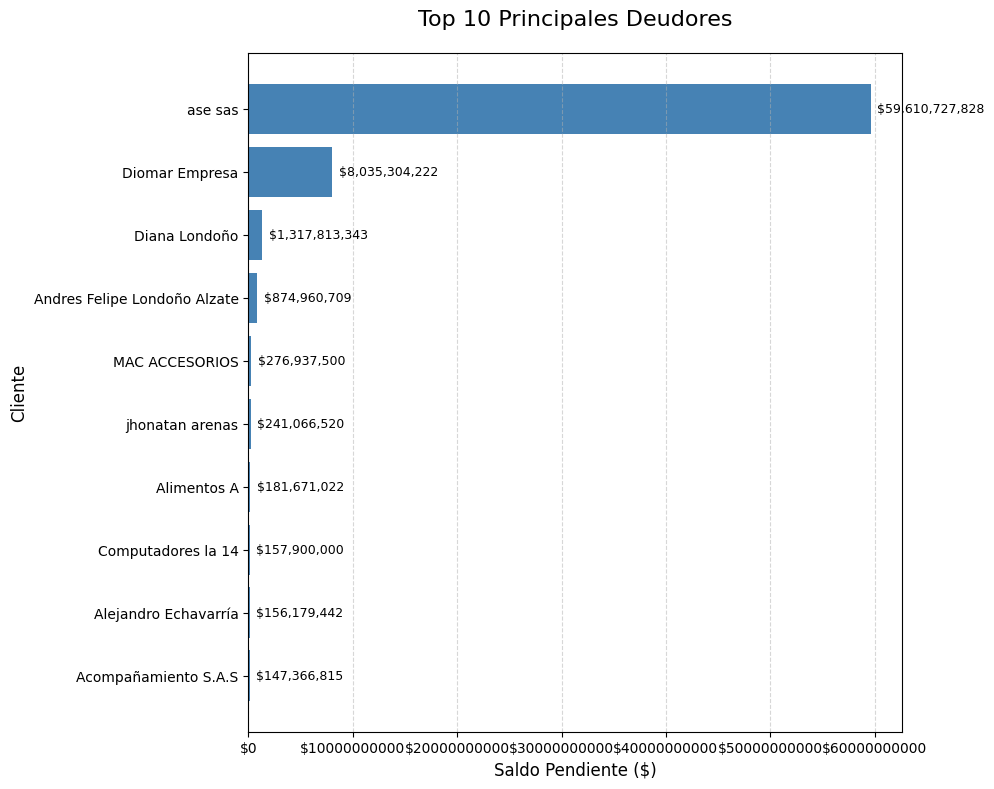

In [119]:


try:
    if 'df_top_debtors' not in locals() or not isinstance(df_top_debtors, pd.DataFrame):
        print("La DataFrame 'df_top_debtors' no se encontró o no es válida.")
        print("Asegúrate de haber ejecutado la celda anterior del script de CxC completo.")
        raise NameError("df_top_debtors no definida. Ejecuta la celda anterior.")


    if not df_top_debtors.empty and 'Cliente' in df_top_debtors.columns and 'Saldo Pendiente' in df_top_debtors.columns:
        df_plot_data = df_top_debtors.head(10).copy()
        df_plot_data.sort_values(by='Saldo Pendiente', ascending=True, inplace=True)

        plt.figure(figsize=(10, 8))
        bars = plt.barh(df_plot_data['Cliente'], df_plot_data['Saldo Pendiente'], color='steelblue')
        
        plt.xlabel('Saldo Pendiente ($)', fontsize=12)
        plt.ylabel('Cliente', fontsize=12)
        plt.title('Top 10 Principales Deudores', fontsize=16, pad=20)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        
        formatter = mtick.FormatStrFormatter('$%1.0f')
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.grid(axis='x', linestyle='--', alpha=0.5)

        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + plt.gca().get_xlim()[1] * 0.01
            if width > 0 :
                plt.text(label_x_pos, bar.get_y() + bar.get_height()/2., f'${width:,.0f}',
                        va='center', ha='left', fontsize=9)

        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos de principales deudores para graficar, o 'df_top_debtors' no tiene el formato esperado.")
        print("Verifica la ejecución de la celda anterior y la estructura de 'df_top_debtors'.")

except NameError as ne:
     print(f"Error: {ne}")
     print("Asegúrate de haber ejecutado la celda anterior que define 'df_top_debtors'.")
except Exception as e:
    print(f"Ocurrió un error inesperado al generar la gráfica de principales deudores: {e}")
    import traceback
    print(traceback.format_exc())

--- Conexión a la base de datos establecida para Valoración de Inventario ---

--- Cargando datos para valoración de inventario... ---
Items cargados: 455
Balance de items cargado: 377
Categorías de items cargadas: 113
Almacenes cargados: 8

--- Combinando datos... ---

--- VALORACIÓN TOTAL DEL INVENTARIO (usando 'fixed_sales_value' como proxy de costo) ---
$3,554.00


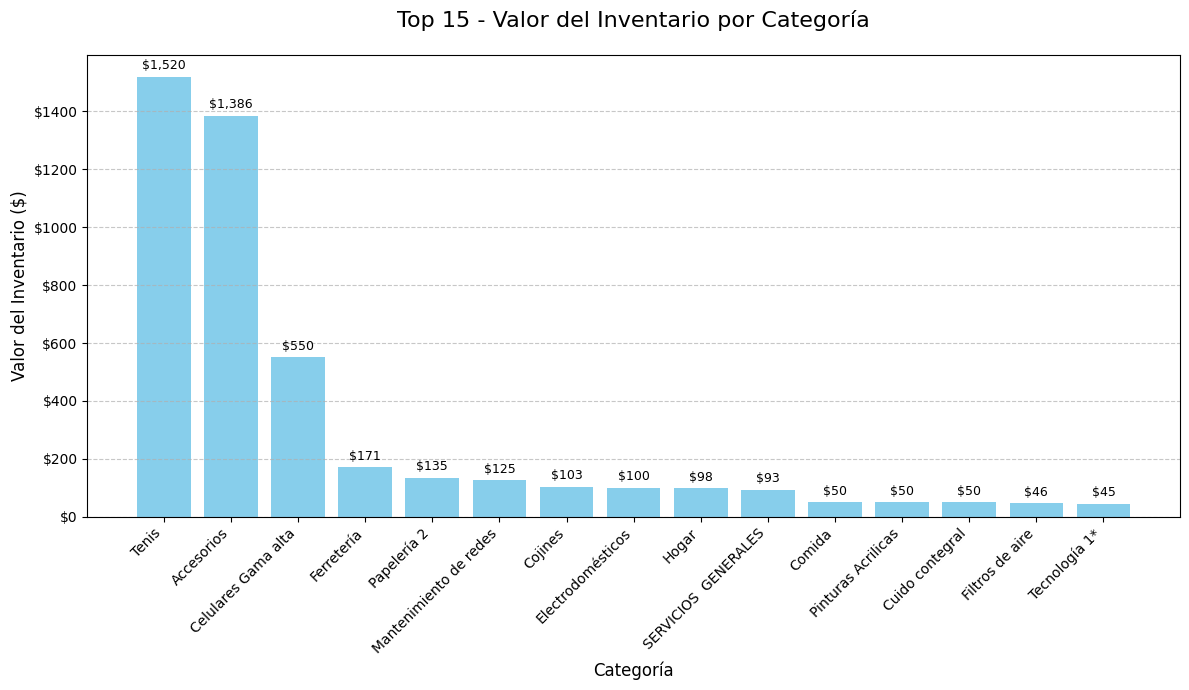

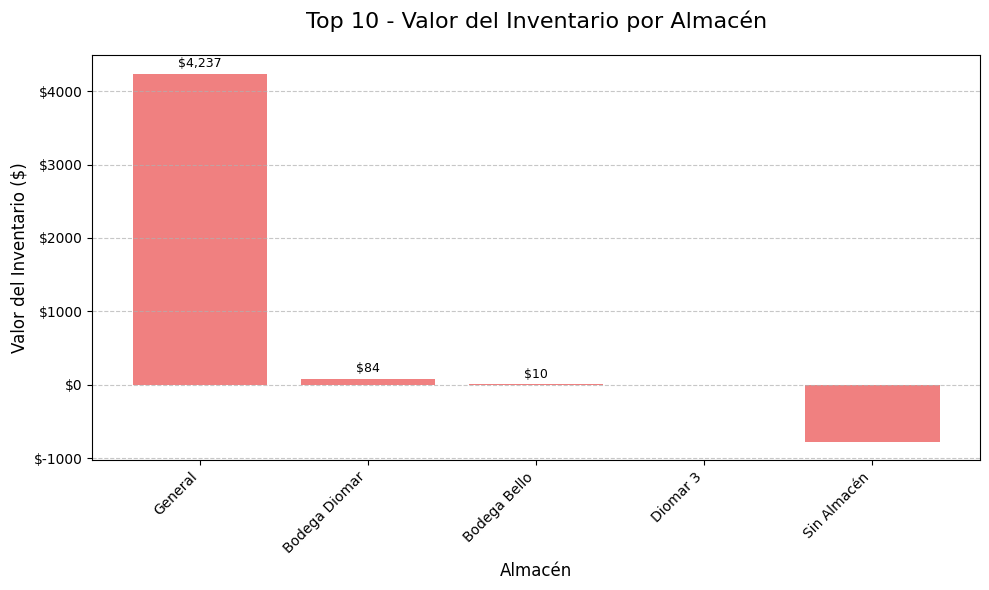

In [120]:

table_items = "items"
col_item_id = "id"
col_item_name = "name" 
col_item_cost_proxy = "fixed_sales_value" 
col_item_category_id = "category_id"

table_item_balance = "item_balance"
col_balance_item_id = "item_id"
col_balance_quantity = "quantity"
col_balance_warehouse_id = "warehouse_id"

table_item_categories = "item_categories"
col_category_id = "id"
col_category_name = "name"

table_warehouses = "warehouses"
col_warehouse_id = "id"
col_warehouse_name = "name"


try:
    contraseña_escapada = quote_plus(contraseña)
    engine = create_engine(f"mysql+pymysql://{usuario}:{contraseña_escapada}@{host}:{puerto}/{basededatos}")
    print("--- Conexión a la base de datos establecida para Valoración de Inventario ---")

    print("\n--- Cargando datos para valoración de inventario... ---")
    
    query_items = f"SELECT {col_item_id}, {col_item_name}, {col_item_cost_proxy}, {col_item_category_id} FROM {table_items}"
    df_items = pd.read_sql(query_items, engine)
    df_items.rename(columns={col_item_cost_proxy: 'cost_proxy', col_item_id: 'item_id_ref'}, inplace=True)
    print(f"Items cargados: {len(df_items)}")

    query_item_balance = f"SELECT {col_balance_item_id}, {col_balance_quantity}, {col_balance_warehouse_id} FROM {table_item_balance}"
    df_item_balance = pd.read_sql(query_item_balance, engine)
    print(f"Balance de items cargado: {len(df_item_balance)}")

    query_item_categories = f"SELECT {col_category_id}, {col_category_name} FROM {table_item_categories}"
    df_item_categories = pd.read_sql(query_item_categories, engine)
    df_item_categories.rename(columns={col_category_name: 'category_name', col_category_id: 'category_id_ref'}, inplace=True)
    print(f"Categorías de items cargadas: {len(df_item_categories)}")

    query_warehouses = f"SELECT {col_warehouse_id}, {col_warehouse_name} FROM {table_warehouses}"
    df_warehouses = pd.read_sql(query_warehouses, engine)
    df_warehouses.rename(columns={col_warehouse_name: 'warehouse_name', col_warehouse_id: 'warehouse_id_ref'}, inplace=True)
    print(f"Almacenes cargados: {len(df_warehouses)}")

    print("\n--- Combinando datos... ---")
    df_merged = pd.merge(df_item_balance, df_items, left_on=col_balance_item_id, right_on='item_id_ref', how='left')
    
    df_merged = pd.merge(df_merged, df_item_categories, left_on=col_item_category_id, right_on='category_id_ref', how='left')
    
    df_merged = pd.merge(df_merged, df_warehouses, left_on=col_balance_warehouse_id, right_on='warehouse_id_ref', how='left')

    df_merged['cost_proxy'] = df_merged['cost_proxy'].fillna(0) 
    df_merged['category_name'] = df_merged['category_name'].fillna('Sin Categoría')
    df_merged['warehouse_name'] = df_merged['warehouse_name'].fillna('Sin Almacén')
    df_merged[col_balance_quantity] = df_merged[col_balance_quantity].fillna(0)


    # --- 3. Calcular Valor del Inventario ---
    df_merged['inventory_value'] = df_merged[col_balance_quantity] * df_merged['cost_proxy']
    
    # --- 4. Calcular Agregaciones ---
    total_inventory_value = df_merged['inventory_value'].sum()
    
    # Valor por categoría
    df_value_by_category = df_merged.groupby('category_name')['inventory_value'].sum().reset_index()
    df_value_by_category = df_value_by_category.sort_values(by='inventory_value', ascending=False)
    
    # Valor por almacén
    df_value_by_warehouse = df_merged.groupby('warehouse_name')['inventory_value'].sum().reset_index()
    df_value_by_warehouse = df_value_by_warehouse.sort_values(by='inventory_value', ascending=False)

    print(f"\n--- VALORACIÓN TOTAL DEL INVENTARIO (usando '{col_item_cost_proxy}' como proxy de costo) ---")
    print(f"${total_inventory_value:,.2f}")

    
    if not df_value_by_category.empty:
        plt.figure(figsize=(12, 7))
        bars_cat = plt.bar(df_value_by_category['category_name'].head(15), df_value_by_category['inventory_value'].head(15), color='skyblue') # Top 15 categorías
        plt.title('Top 15 - Valor del Inventario por Categoría', fontsize=16, pad=20)
        plt.xlabel('Categoría', fontsize=12)
        plt.ylabel('Valor del Inventario ($)', fontsize=12)
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.yticks(fontsize=10)
        formatter = mtick.FormatStrFormatter('$%1.0f')
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for bar in bars_cat:
            yval = bar.get_height()
            if yval > 0: plt.text(bar.get_x() + bar.get_width()/2.0, yval + plt.gca().get_ylim()[1]*0.01, f'${yval:,.0f}', ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print("No hay suficientes datos para graficar el valor del inventario por categoría.")

    if not df_value_by_warehouse.empty:
        plt.figure(figsize=(10, 6))
        bars_wh = plt.bar(df_value_by_warehouse['warehouse_name'].head(10), df_value_by_warehouse['inventory_value'].head(10), color='lightcoral') # Top 10 almacenes
        plt.title('Top 10 - Valor del Inventario por Almacén', fontsize=16, pad=20)
        plt.xlabel('Almacén', fontsize=12)
        plt.ylabel('Valor del Inventario ($)', fontsize=12)
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.yticks(fontsize=10)
        formatter = mtick.FormatStrFormatter('$%1.0f')
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for bar in bars_wh:
            yval = bar.get_height()
            if yval > 0: plt.text(bar.get_x() + bar.get_width()/2.0, yval + plt.gca().get_ylim()[1]*0.01, f'${yval:,.0f}', ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print("No hay suficientes datos para graficar el valor del inventario por almacén.")

except Exception as e:
    print(f"Ocurrió un error general en el script de Valoración de Inventario: {e}")
    import traceback
    print(traceback.format_exc())



--- Conexión a la base de datos establecida para Análisis de Stock Lento ---

--- Cargando datos para análisis de stock lento... ---
Items cargados: 455
Balance de items (stock actual > 0) cargado y agregado: 56
Kardex de items cargado: 524
Categorías de items cargadas: 113

--- Identificando última fecha de salida por ítem... ---
Ítems con movimientos de salida encontrados: 65

--- Combinando datos para análisis... ---
Ítems considerados de lenta rotación (más de 90 días inactivos): 56

--- Top 10 Ítems de Lenta Rotación (por Valor, >90 días) ---
                     Ítem  Stock Actual Valor Stock Lento ($)  Días Inactivo              Categoría
Zapato Casual / S / Negra        1520.0                $1,520           1125                  Tenis
                  Pruebas        1200.0                $1,200            391             Accesorios
        Celular tal marca         450.0                  $450           1188    Celulares Gama alta
             Martillo 2 M         181.0       

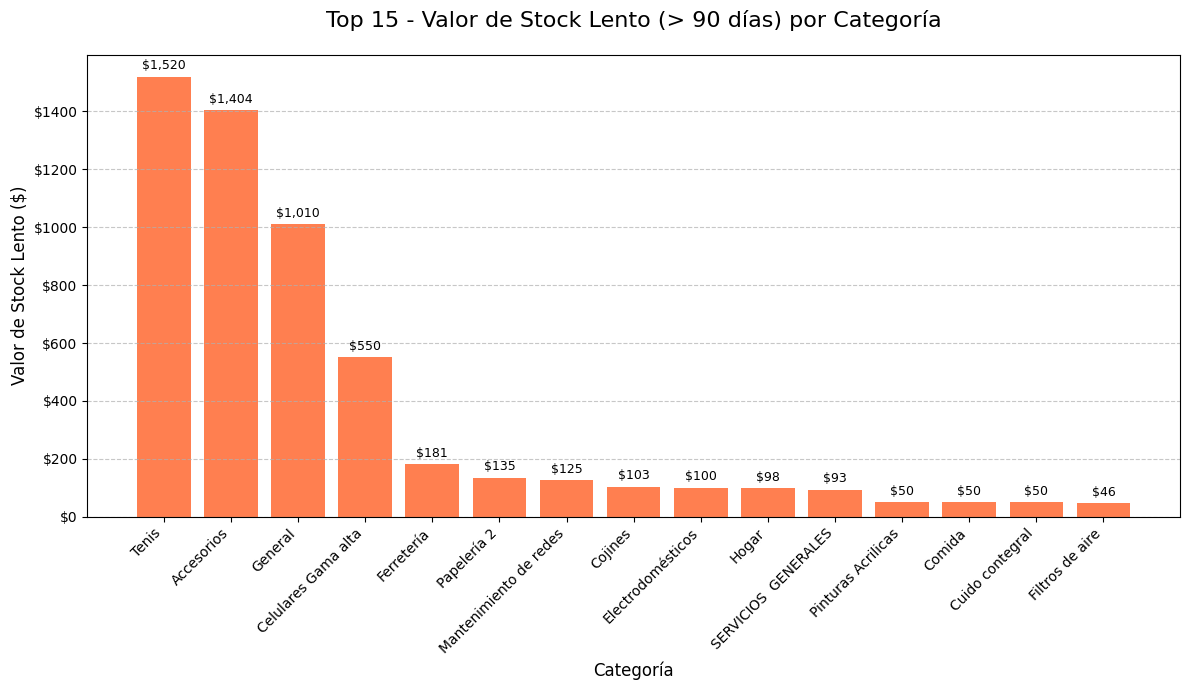

In [121]:

table_items = "items"
col_item_id_items = "id"
col_item_name = "name"
col_item_cost_proxy = "fixed_sales_value"
col_item_category_id = "category_id"
col_item_created_at = "created_at" 

table_item_balance = "item_balance"
col_balance_item_id = "item_id"
col_balance_quantity_on_hand = "quantity"

table_item_kardex = "item_kardex"
col_kardex_item_id = "item_id"
col_kardex_movement_date = "date"
col_kardex_quantity_moved = "quantity"

table_item_categories = "item_categories"
col_category_id_categories = "id" 
col_category_name = "name"

current_date_for_analysis = pd.Timestamp('2025-05-20')
slow_moving_threshold_days = 90

try:
    contraseña_escapada = quote_plus(contraseña)
    engine = create_engine(f"mysql+pymysql://{usuario}:{contraseña_escapada}@{host}:{puerto}/{basededatos}")
    print("--- Conexión a la base de datos establecida para Análisis de Stock Lento ---")

    print("\n--- Cargando datos para análisis de stock lento... ---")
    
    query_items = f"SELECT {col_item_id_items}, {col_item_name}, {col_item_cost_proxy}, {col_item_category_id}, {col_item_created_at} FROM {table_items}"
    df_items = pd.read_sql(query_items, engine)
    df_items.rename(columns={col_item_id_items: 'item_id'}, inplace=True)
    df_items[col_item_created_at] = pd.to_datetime(df_items[col_item_created_at], errors='coerce')
    print(f"Items cargados: {len(df_items)}")

    query_item_balance = f"SELECT {col_balance_item_id}, {col_balance_quantity_on_hand} FROM {table_item_balance}"
    df_item_balance = pd.read_sql(query_item_balance, engine)
    df_item_balance = df_item_balance.groupby(col_balance_item_id)[col_balance_quantity_on_hand].sum().reset_index()
    df_item_balance.rename(columns={col_balance_item_id: 'item_id', col_balance_quantity_on_hand: 'qty_on_hand'}, inplace=True)
    df_item_balance = df_item_balance[df_item_balance['qty_on_hand'] > 0]
    print(f"Balance de items (stock actual > 0) cargado y agregado: {len(df_item_balance)}")

    query_item_kardex = f"SELECT {col_kardex_item_id}, {col_kardex_movement_date}, {col_kardex_quantity_moved} FROM {table_item_kardex}"
    df_item_kardex = pd.read_sql(query_item_kardex, engine)
    df_item_kardex.rename(columns={col_kardex_item_id: 'item_id', col_kardex_movement_date: 'movement_date', col_kardex_quantity_moved: 'qty_moved'}, inplace=True)
    df_item_kardex['movement_date'] = pd.to_datetime(df_item_kardex['movement_date'], errors='coerce')
    print(f"Kardex de items cargado: {len(df_item_kardex)}")

    query_item_categories = f"SELECT {col_category_id_categories}, {col_category_name} FROM {table_item_categories}"
    df_item_categories = pd.read_sql(query_item_categories, engine)
    df_item_categories.rename(columns={col_category_id_categories: 'category_id', col_category_name: 'category_name'}, inplace=True)
    print(f"Categorías de items cargadas: {len(df_item_categories)}")

    print("\n--- Identificando última fecha de salida por ítem... ---")
    df_outgoing_movements = df_item_kardex[df_item_kardex['qty_moved'] < 0].copy()
    
    if not df_outgoing_movements.empty:
        df_outgoing_movements.dropna(subset=['movement_date'], inplace=True) # Eliminar filas con fechas nulas
        df_last_outgoing_date = df_outgoing_movements.loc[df_outgoing_movements.groupby('item_id')['movement_date'].idxmax()]
        df_last_outgoing_date = df_last_outgoing_date[['item_id', 'movement_date']].rename(columns={'movement_date': 'last_outgoing_date'})
        print(f"Ítems con movimientos de salida encontrados: {len(df_last_outgoing_date)}")
    else:
        print("No se encontraron movimientos de salida en el kardex (qty_moved < 0).")
        df_last_outgoing_date = pd.DataFrame(columns=['item_id', 'last_outgoing_date'])

    print("\n--- Combinando datos para análisis... ---")
    df_analysis = pd.merge(df_item_balance, df_items, on='item_id', how='left')
    df_analysis = pd.merge(df_analysis, df_last_outgoing_date, on='item_id', how='left')

    df_analysis['last_activity_date'] = df_analysis['last_outgoing_date'].fillna(df_analysis[col_item_created_at])
    
    df_analysis.dropna(subset=['last_activity_date', col_item_cost_proxy], inplace=True)

    if not df_analysis.empty:
        df_analysis['days_inactive'] = (current_date_for_analysis - df_analysis['last_activity_date']).dt.days
        df_analysis['inventory_value'] = df_analysis['qty_on_hand'] * df_analysis[col_item_cost_proxy]
        
        df_slow_moving_stock = df_analysis[df_analysis['days_inactive'] > slow_moving_threshold_days].copy()
        print(f"Ítems considerados de lenta rotación (más de {slow_moving_threshold_days} días inactivos): {len(df_slow_moving_stock)}")

        if not df_slow_moving_stock.empty:
            df_slow_moving_stock = pd.merge(df_slow_moving_stock, df_item_categories, on='category_id', how='left')
            df_slow_moving_stock['category_name'] = df_slow_moving_stock['category_name'].fillna('Sin Categoría')

            print(f"\n--- Top 10 Ítems de Lenta Rotación (por Valor, >{slow_moving_threshold_days} días) ---")
            df_top_slow_items = df_slow_moving_stock.sort_values(by='inventory_value', ascending=False)
            df_display_slow = df_top_slow_items[[col_item_name, 'qty_on_hand', 'inventory_value', 'days_inactive', 'category_name']].head(10).copy()
            df_display_slow.rename(columns={
                col_item_name: 'Ítem', 
                'qty_on_hand': 'Stock Actual', 
                'inventory_value': 'Valor Stock Lento ($)',
                'days_inactive': 'Días Inactivo',
                'category_name': 'Categoría'
            }, inplace=True)
            df_display_slow['Valor Stock Lento ($)'] = df_display_slow['Valor Stock Lento ($)'].map('${:,.0f}'.format)
            print(df_display_slow.to_string(index=False))

            df_slow_by_category = df_slow_moving_stock.groupby('category_name')['inventory_value'].sum().reset_index()
            df_slow_by_category = df_slow_by_category.sort_values(by='inventory_value', ascending=False)

            if not df_slow_by_category.empty:
                plt.figure(figsize=(12, 7))
                bars_cat_slow = plt.bar(df_slow_by_category['category_name'].head(15), df_slow_by_category['inventory_value'].head(15), color='coral') # Top 15
                plt.title(f'Top 15 - Valor de Stock Lento (> {slow_moving_threshold_days} días) por Categoría', fontsize=16, pad=20)
                plt.xlabel('Categoría', fontsize=12)
                plt.ylabel('Valor de Stock Lento ($)', fontsize=12)
                plt.xticks(rotation=45, ha="right", fontsize=10)
                plt.yticks(fontsize=10)
                formatter = mtick.FormatStrFormatter('$%1.0f')
                plt.gca().yaxis.set_major_formatter(formatter)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                for bar in bars_cat_slow:
                    yval = bar.get_height()
                    if yval > 0: plt.text(bar.get_x() + bar.get_width()/2.0, yval + plt.gca().get_ylim()[1]*0.01, f'${yval:,.0f}', ha='center', va='bottom', fontsize=9)
                plt.tight_layout()
                plt.show()
            else:
                print("No hay suficientes datos para graficar el valor del stock lento por categoría.")
        else:
            print(f"¡Buenas noticias! No se encontró stock de lenta rotación con más de {slow_moving_threshold_days} días de inactividad.")
    else:
        print("No hay datos suficientes en el inventario o kardex para realizar el análisis de stock lento después de los filtros iniciales.")

except Exception as e:
    print(f"Ocurrió un error general en el script de Análisis de Stock Lento: {e}")
    import traceback
    print(traceback.format_exc())



--- Conexión a la base de datos establecida para Análisis de Velocidad de Ventas ---

--- Cargando datos para análisis de velocidad de ventas... ---
Items cargados: 455
Kardex de items cargado: 524

--- Calculando ventas reales de los últimos 90 días... ---
No se encontraron movimientos de salida recientes en el kardex con datos reales.

No se encontraron ventas reales significativas en los últimos 90 días. SIMULANDO datos de ventas...
Se simularon ventas para 273 ítems.


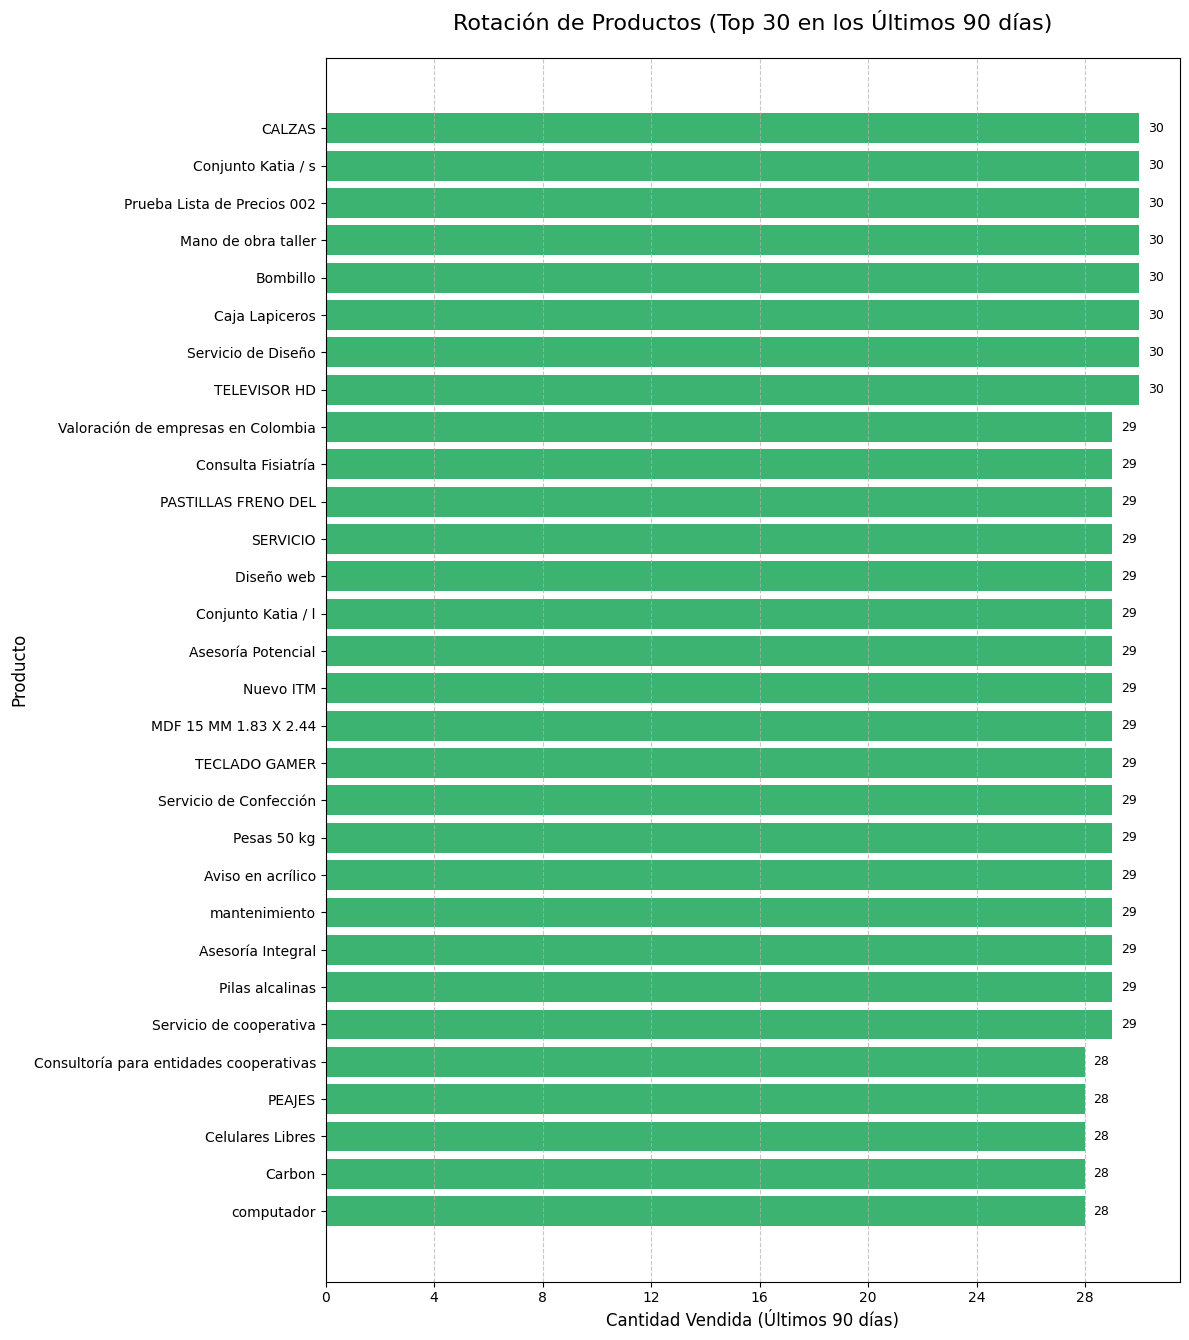

In [122]:

table_items = "items"
col_item_id_items = "id"
col_item_name = "name"

table_item_kardex = "item_kardex"
col_kardex_item_id = "item_id"
col_kardex_movement_date = "date"
col_kardex_quantity_moved = "quantity" 

current_date_for_analysis = pd.Timestamp('2025-05-20') 
period_days_for_sales_velocity = 90
num_items_to_display = 30 


try:
    contraseña_escapada = quote_plus(contraseña)
    engine = create_engine(f"mysql+pymysql://{usuario}:{contraseña_escapada}@{host}:{puerto}/{basededatos}")
    print("--- Conexión a la base de datos establecida para Análisis de Velocidad de Ventas ---")

    print("\n--- Cargando datos para análisis de velocidad de ventas... ---")
    
    query_items = f"SELECT {col_item_id_items}, {col_item_name} FROM {table_items}"
    df_items = pd.read_sql(query_items, engine)
    df_items.rename(columns={col_item_id_items: 'item_id'}, inplace=True)
    print(f"Items cargados: {len(df_items)}")

    query_item_kardex = f"SELECT {col_kardex_item_id}, {col_kardex_movement_date}, {col_kardex_quantity_moved} FROM {table_item_kardex}"
    df_item_kardex = pd.read_sql(query_item_kardex, engine)
    df_item_kardex.rename(columns={col_kardex_item_id: 'item_id', 
                                col_kardex_movement_date: 'movement_date', 
                                col_kardex_quantity_moved: 'qty_moved'}, inplace=True)
    df_item_kardex['movement_date'] = pd.to_datetime(df_item_kardex['movement_date'], errors='coerce')
    print(f"Kardex de items cargado: {len(df_item_kardex)}")

    print(f"\n--- Calculando ventas reales de los últimos {period_days_for_sales_velocity} días... ---")
    start_date_period = current_date_for_analysis - timedelta(days=period_days_for_sales_velocity)
    
    df_outgoing_recent = df_item_kardex[
        (df_item_kardex['qty_moved'] < 0) &
        (df_item_kardex['movement_date'] >= start_date_period) &
        (df_item_kardex['movement_date'] <= current_date_for_analysis)
    ].copy()
    
    if not df_outgoing_recent.empty:
        df_outgoing_recent['sold_quantity'] = df_outgoing_recent['qty_moved'].abs()
        df_sales_summary = df_outgoing_recent.groupby('item_id')['sold_quantity'].sum().reset_index()
        print(f"Ítems con ventas reales en el período: {len(df_sales_summary)}")
    else:
        print("No se encontraron movimientos de salida recientes en el kardex con datos reales.")
        df_sales_summary = pd.DataFrame(columns=['item_id', 'sold_quantity'])

    if df_sales_summary.empty or df_sales_summary['sold_quantity'].sum() == 0:
        print(f"\nNo se encontraron ventas reales significativas en los últimos {period_days_for_sales_velocity} días. SIMULANDO datos de ventas...")
        if df_items.empty:
            print("La tabla 'items' está vacía. No se pueden simular ventas para ítems específicos.")
        else:
            percentage_items_with_sales = 0.6
            num_items_total = len(df_items)
            num_items_to_simulate_sales_for = min(num_items_total, max(5, int(num_items_total * percentage_items_with_sales)))
            
            if num_items_to_simulate_sales_for > 0:
                items_for_simulation = df_items.sample(n=num_items_to_simulate_sales_for, replace=False)
                
                simulated_sales_list = []
                for index, item_row in items_for_simulation.iterrows():
                    quantity_sold = random.randint(1, 30)
                    simulated_sales_list.append({
                        'item_id': item_row['item_id'],
                        'sold_quantity': quantity_sold
                    })
                df_sales_summary = pd.DataFrame(simulated_sales_list)
                print(f"Se simularon ventas para {len(df_sales_summary)} ítems.")
            else:
                print("No hay ítems en la tabla 'items' para simular ventas.")
                df_sales_summary = pd.DataFrame(columns=['item_id', 'sold_quantity'])
    else:
        print(f"Se utilizarán datos de ventas reales de los últimos {period_days_for_sales_velocity} días.")



    df_plot_data = pd.merge(df_items, df_sales_summary, on='item_id', how='left')
    df_plot_data['sold_quantity'] = df_plot_data['sold_quantity'].fillna(0)
    
    df_plot_data = df_plot_data.sort_values(by='sold_quantity', ascending=False)
    
  
    df_plot_data_display = df_plot_data.head(num_items_to_display)

    df_plot_data_display = df_plot_data_display.sort_values(by='sold_quantity', ascending=True)

    if not df_plot_data_display.empty:
        plt.figure(figsize=(12, max(8, len(df_plot_data_display) * 0.45)))
        bars = plt.barh(df_plot_data_display[col_item_name], df_plot_data_display['sold_quantity'], 
                        color=['mediumseagreen' if x > 0 else 'lightcoral' for x in df_plot_data_display['sold_quantity']])
        
        plt.xlabel(f'Cantidad Vendida (Últimos {period_days_for_sales_velocity} días)', fontsize=12)
        plt.ylabel('Producto', fontsize=12)
        plt.title(f'Rotación de Productos (Top {num_items_to_display} en los Últimos {period_days_for_sales_velocity} días)', fontsize=16, pad=20)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        
        plt.gca().xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
        plt.grid(axis='x', linestyle='--', alpha=0.7)

        for bar in bars:
            width = bar.get_width()
            plt.text(width + plt.gca().get_xlim()[1]*0.01, 
                     bar.get_y() + bar.get_height()/2., 
                     f'{width:,.0f}', 
                     va='center', ha='left', fontsize=9)

        plt.tight_layout()
        plt.show()
    else:
        print("No hay datos suficientes (reales o simulados) para generar el gráfico de velocidad de ventas.")

except Exception as e:
    print(f"Ocurrió un error general en el script de Velocidad de Ventas: {e}")
    import traceback
    print(traceback.format_exc())

